In [36]:
import networkx as nx
import cirq
import cirq_google
import numpy as np
from matplotlib import pyplot as plt

In [111]:
class Gate:
    def __init__(self, gname, *args):
        self.name = gname
        self.qs = []
        for i in args:
            self.qs.append(i)
        if self.name != "":
            self.gate = getattr(cirq, self.name)

def choose_oneq_gates(gates, depth, num_q):
    #Chooses one one-qubit gate from given for each step in range(depth)
    answer = []
    probs = [[len(gates) for i in range(len(gates))] for j in range(num_q)]
    for i in range(depth):
        ans = []
        for j in range(num_q):
            gate = np.random.choice(gates, p = np.array([1. / i for i in probs[j]]) / sum([1. / i for i in probs[j]]))
            ans.append(gate)
            probs[j][gates.index(gate)] += len(gates)
        answer.append(ans)
    return answer

def choose_qubits_for_CZ(depth, num_q):
    #Chooses qubits to apply CZ to for each step in range(depth)
    ans = []
    odds = [i for i in range(num_q - 1) if i % 2 == 1]
    evens = [i for i in range(num_q - 1) if i % 2 == 0]
    vrs = [odds, evens]
    probs = [2, 2]
    for i in range(depth):
        qs = np.random.choice([i for i in range(len(probs))], p = np.array([1. / i for i in probs]) / sum([1. / i for i in probs]))
        probs[qs] += len(vrs)
        ans.append(np.array(vrs[qs]))
    return ans

### Generate Gate Sequence

In [120]:
num_q = 5
depth = 3

oneq_gates = ["T", "rx", "ry"]
seq_oneq_gates = choose_oneq_gates(oneq_gates, depth, num_q)
seq_cz_qubits = choose_qubits_for_CZ(depth, num_q)

gates = []
nodes = []

for i in range(num_q):
    gates.append(Gate("H", i))
    nodes.append((i, {"subset" : 0}))

cnt = num_q
for i in range(depth):
    for v in range(num_q):
        if v in seq_cz_qubits[i]:
            gates.append(Gate("CZ", v, v + 1))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1
        elif v not in seq_cz_qubits[i] and v not in seq_cz_qubits[i] + 1:
            gates.append(Gate(""))
            nodes.append((cnt, {"subset" : 2 * i + 1}))
            cnt += 1

    for j in range(num_q):
        gates.append(Gate(seq_oneq_gates[i][j], j))
        nodes.append((cnt, {"subset" : 2 * i + 2}))
        cnt += 1

In [121]:
# for g in gates:
#     print(g.name, g.qs)

### Create Graph

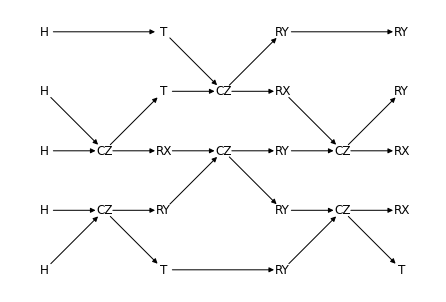

In [122]:
G = nx.DiGraph()
G.add_nodes_from(nodes)

cur_gate = np.array([i for i in range(num_q)])
cur = num_q
for gate in gates[num_q:]:
    for i in gate.qs:
        G.add_edge(cur_gate[i], cur)
        cur_gate[i] = cur
    cur += 1
    
pos = nx.multipartite_layout(G)
labeldict = {}
for i in range(len(gates)):
    labeldict[i] = gates[i].name.upper()
nx.draw(G, pos, labels = labeldict, with_labels = True, node_color = 'none')

### Simulate on LineQubit

In [123]:
q_line = cirq.LineQubit.range(num_q)
line_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        line_circuit.append(gate.gate(q_line[gate.qs[0]]))
    elif len(gate.qs) == 1:
        line_circuit.append(gate.gate(np.pi / 2)(q_line[gate.qs[0]]))
    elif len(gate.qs) == 2:
        line_circuit.append(gate.gate(q_line[gate.qs[0]], q_line[gate.qs[1]]))
print(line_circuit)

0: ───H───T──────────────@──────────Ry(0.5π)───Ry(0.5π)──────────────
                         │
1: ───H───@───T──────────@──────────Rx(0.5π)───@──────────Ry(0.5π)───
          │                                    │
2: ───H───@───Rx(0.5π)───@──────────Ry(0.5π)───@──────────Rx(0.5π)───
                         │
3: ───H───@───Ry(0.5π)───@──────────Ry(0.5π)───@──────────Rx(0.5π)───
          │                                    │
4: ───H───@───T──────────Ry(0.5π)──────────────@──────────T──────────


In [124]:
sim = cirq.Simulator()
results_line = sim.simulate(line_circuit)
print(results_line)

measurements: (no measurements)
output vector: [-2.13388294e-01-3.66116315e-02j -1.76776648e-01+1.24999978e-01j
 -8.83883089e-02-8.83883238e-02j  1.24999955e-01+1.11758709e-08j
  2.13388294e-01-3.66116613e-02j  1.24999955e-01-1.76776662e-01j
 -8.83883238e-02+8.83883238e-02j  0.00000000e+00-1.24999963e-01j
  8.83883238e-02-8.83883089e-02j  1.11758709e-08-1.24999955e-01j
  3.66116315e-02-2.13388294e-01j  1.24999978e-01+1.76776648e-01j
 -8.83883238e-02-8.83883238e-02j -1.24999963e-01+0.00000000e+00j
  3.66116613e-02+2.13388294e-01j -1.76776662e-01-1.24999955e-01j
 -1.24999993e-01-7.45058060e-09j -8.83883461e-02+8.83883312e-02j
  1.76776648e-01+1.24999993e-01j -2.13388294e-01+3.66116241e-02j
 -7.45058060e-09+1.24999970e-01j  8.83883163e-02+8.83883312e-02j
  1.24999985e-01+1.76776648e-01j -2.13388294e-01-3.66116241e-02j
 -1.24999993e-01+1.76776648e-01j  3.66116241e-02+2.13388294e-01j
  7.45058060e-09-1.24999993e-01j  8.83883312e-02+8.83883461e-02j
 -1.76776648e-01+1.24999985e-01j -3.6611624

### Simulate with Swaps

In [125]:
q_cross = []
#В начале в центре первый кубит (можем применять CZ на пары (0,1) и (1,2)), при необходимости меняем его и третий (получаем оставшиеся пары (2,3) и (3,4))
q_cross.append(cirq.GridQubit(0, 1))    #qubit 0
q_cross.append(cirq.GridQubit(1, 1))    #qubit 1
q_cross.append(cirq.GridQubit(1, 0))    #qubit 2
q_cross.append(cirq.GridQubit(1, 2))    #qubit 3
q_cross.append(cirq.GridQubit(2, 1))    #qubit 4
qubits = [i for i in range(num_q)]

def crs(q):
    return qubits.index(q)
def swap(qubits):
    sw = qubits[1]
    qubits[1] = qubits[3]
    qubits[3] = sw    

cross_circuit = cirq.Circuit()

for gate in gates:        
    if len(gate.qs) == 1 and gate.name[0] != 'r':
        cross_circuit.append(gate.gate(q_cross[crs(gate.qs[0])]))
    elif len(gate.qs) == 1:
        cross_circuit.append(gate.gate(np.pi / 2)(q_cross[crs(gate.qs[0])]))
    elif len(gate.qs) == 2:
        if (3 in gate.qs and qubits[1] == 1) or (1 in gate.qs and qubits[1] == 3):
            qb = crs(gate.qs[1 - gate.qs.index(4 - qubits[1])])
            cross_circuit.append(cirq.SWAP(q_cross[crs(1)], q_cross[crs(3)]))
            swap(qubits)
        else:
            qb = crs(gate.qs[1 - gate.qs.index(qubits[1])])
        cross_circuit.append(gate.gate(q_cross[1], q_cross[qb]))
if qubits[1] == 3:
    cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[3]))
cross_circuit.append(cirq.SWAP(q_cross[1], q_cross[2]))
print(cross_circuit)

                              ┌──┐                                                                                 ┌─────────┐
(0, 1): ───H───T───────────────────────────────────────────@───Ry(0.5π)───Ry(0.5π)──────────────────────────────────────────────────────────────────
                                                           │
(1, 0): ───H───@───Rx(0.5π)────────────────────────────────┼──────────────@──────────Ry(0.5π)───────@───Rx(0.5π)────────────────────────────────×───
               │                                           │              │                         │                                           │
(1, 1): ───H───@───×───────────@─────Ry(0.5π)───×──────────@───×──────────@──────────Ry(0.5π)───×───@───×───────────@────────────Rx(0.5π)───×───×───
                   │           │                │              │                                │       │           │                       │
(1, 2): ───H───────×───────────┼T───────────────×──────────────×──────────Rx(

In [126]:
sim_cross = cirq.Simulator()
results_cross = sim_cross.simulate(cross_circuit)
print(results_cross)

measurements: (no measurements)
output vector: [-2.13388264e-01-3.66116390e-02j -1.76776618e-01+1.24999940e-01j
 -8.83883014e-02-8.83882940e-02j  1.24999925e-01-3.72529030e-09j
  2.13388264e-01-3.66116464e-02j  1.24999940e-01-1.76776618e-01j
 -8.83883163e-02+8.83883238e-02j -3.72529030e-09-1.24999955e-01j
  8.83882940e-02-8.83883014e-02j -3.72529030e-09-1.24999925e-01j
  3.66116390e-02-2.13388264e-01j  1.24999940e-01+1.76776618e-01j
 -8.83883238e-02-8.83883163e-02j -1.24999955e-01+3.72529030e-09j
  3.66116464e-02+2.13388264e-01j -1.76776618e-01-1.24999940e-01j
 -1.24999955e-01+0.00000000e+00j -8.83883163e-02+8.83883163e-02j
  1.76776633e-01+1.24999955e-01j -2.13388264e-01+3.66116390e-02j
  0.00000000e+00+1.24999955e-01j  8.83883163e-02+8.83883163e-02j
  1.24999955e-01+1.76776603e-01j -2.13388249e-01-3.66116166e-02j
 -1.24999955e-01+1.76776633e-01j  3.66116390e-02+2.13388264e-01j
  0.00000000e+00-1.24999955e-01j  8.83883163e-02+8.83883163e-02j
 -1.76776603e-01+1.24999955e-01j -3.6611616

### Results comparison

In [127]:
np.round(results_line.final_state_vector - results_cross.final_state_vector, 3)
#Результаты одинаковые

array([-0.+0.j, -0.+0.j, -0.-0.j,  0.+0.j,  0.-0.j,  0.-0.j, -0.+0.j,
        0.-0.j,  0.-0.j,  0.-0.j, -0.-0.j,  0.+0.j,  0.-0.j, -0.-0.j,
        0.+0.j, -0.-0.j, -0.-0.j, -0.+0.j,  0.+0.j, -0.-0.j, -0.+0.j,
        0.+0.j,  0.+0.j, -0.-0.j, -0.+0.j, -0.+0.j,  0.-0.j,  0.+0.j,
       -0.+0.j, -0.+0.j, -0.-0.j,  0.+0.j], dtype=complex64)